## TODO
1. check airports
1. diff train test

In [1]:
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

import xgboost as xgb

In [2]:
def label_encode(train_data, test_data, columns):
    'Returns a DataFrame with encoded columns'
    encoded_cols = []
    for col in columns:
        factorised = pd.factorize(train_data[col])[1]
        labels = pd.Series(range(len(factorised)), index=factorised)
        encoded_col_train = train_data[col].map(labels) 
        encoded_col_test = test_data[col].map(labels)
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = -1
        encoded_cols.append(pd.DataFrame({'label_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])

def freq_encode(train_data, test_data, columns):
    '''Returns a DataFrame with encoded columns'''
    encoded_cols = []
    nsamples = train_data.shape[0]
    for col in columns:    
        freqs_cat = train_data.groupby(col)[col].count()/nsamples
        encoded_col_train = train_data[col].map(freqs_cat)
        encoded_col_test = test_data[col].map(freqs_cat)
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = 0
        encoded_cols.append(pd.DataFrame({'freq_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])

def mean_encode(train_data, test_data, columns, target_col, reg_method=None,
                alpha=0, add_random=False, rmean=0, rstd=0.1, folds=1):
    '''Returns a DataFrame with encoded columns'''
    encoded_cols = []
    target_mean_global = train_data[target_col].mean()
    for col in columns:
        # Getting means for test data
        nrows_cat = train_data.groupby(col)[target_col].count()
        target_means_cats = train_data.groupby(col)[target_col].mean()
        target_means_cats_adj = (target_means_cats*nrows_cat + 
                                 target_mean_global*alpha)/(nrows_cat+alpha)
        # Mapping means to test data
        encoded_col_test = test_data[col].map(target_means_cats_adj)
        # Getting a train encodings
        if reg_method == 'expanding_mean':
            train_data_shuffled = train_data.sample(frac=1, random_state=1)
            cumsum = train_data_shuffled.groupby(col)[target_col].cumsum() - train_data_shuffled[target_col]
            cumcnt = train_data_shuffled.groupby(col).cumcount()
            encoded_col_train = cumsum/(cumcnt)
            encoded_col_train.fillna(target_mean_global, inplace=True)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))
        elif (reg_method == 'k_fold') and (folds > 1):
            kfold = StratifiedKFold(folds, shuffle=True, random_state=1)
            parts = []
            for tr_in, val_ind in kfold.split(train_data[columns].values, train_data[target_col].values):
                # divide data
                df_for_estimation, df_estimated = train_data.iloc[tr_in], train_data.iloc[val_ind]
                # getting means on data for estimation (all folds except estimated)
                nrows_cat = df_for_estimation.groupby(col)[target_col].count()
                target_means_cats = df_for_estimation.groupby(col)[target_col].mean()
                target_means_cats_adj = (target_means_cats*nrows_cat + 
                                         target_mean_global*alpha)/(nrows_cat+alpha)
                # Mapping means to estimated fold
                encoded_col_train_part = df_estimated[col].map(target_means_cats_adj)
                if add_random:
                    encoded_col_train_part = encoded_col_train_part + normal(loc=rmean, scale=rstd, 
                                                                             size=(encoded_col_train_part.shape[0]))
                # Saving estimated encodings for a fold
                parts.append(encoded_col_train_part)
            encoded_col_train = pd.concat(parts, axis=0)
            encoded_col_train.fillna(target_mean_global, inplace=True)
        else:
            encoded_col_train = train_data[col].map(target_means_cats_adj)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))

        # Saving the column with means
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = target_mean_global
        encoded_cols.append(pd.DataFrame({'mean_'+target_col+'_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])

In [3]:
PATH_TO_DATA = Path('../input/flight-delays-fall-2018/')

train_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_train.csv')
test_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_test.csv')
air = pd.read_csv(PATH_TO_DATA / 'airports.csv')
air = air.set_index('IATA_CODE')

train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
air.head()

,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
IATA_CODE,,,,,,
ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


### Analyze air

In [5]:
air_city = air['CITY'].to_dict()
air_state = air['STATE'].to_dict()
air_country = air['COUNTRY'].to_dict()
air_lat = air['LATITUDE'].to_dict()
air_long = air['LONGITUDE'].to_dict()

### Analyze train-test

In [6]:
for df in [train_df, test_df]:
    df['Month'] = df['Month'].apply(lambda x: int(x[2:]))
    df['DayofMonth'] = df['DayofMonth'].apply(lambda x: int(x[2:]))
    df['DayOfWeek'] = df['DayOfWeek'].apply(lambda x: int(x[2:]))
    if 'dep_delayed_15min' in df.columns:
        df['target'] = df['dep_delayed_15min'].map({'N':0, 'Y':1})

    df['DepTime'] = df['DepTime'].apply(lambda x: (x // 100) * 60 + x % 100)

In [7]:
train_df['is_test'] = False 
test_df['is_test'] = True 
df = pd.concat([train_df, test_df], axis=0, sort=False).reset_index(drop=True)
df.shape

(200000, 11)

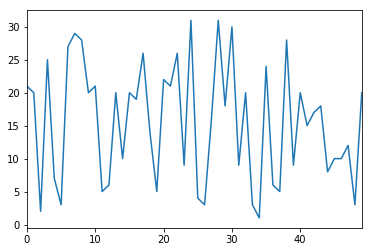

In [61]:
train_df['DayofMonth'].iloc[:50].plot();

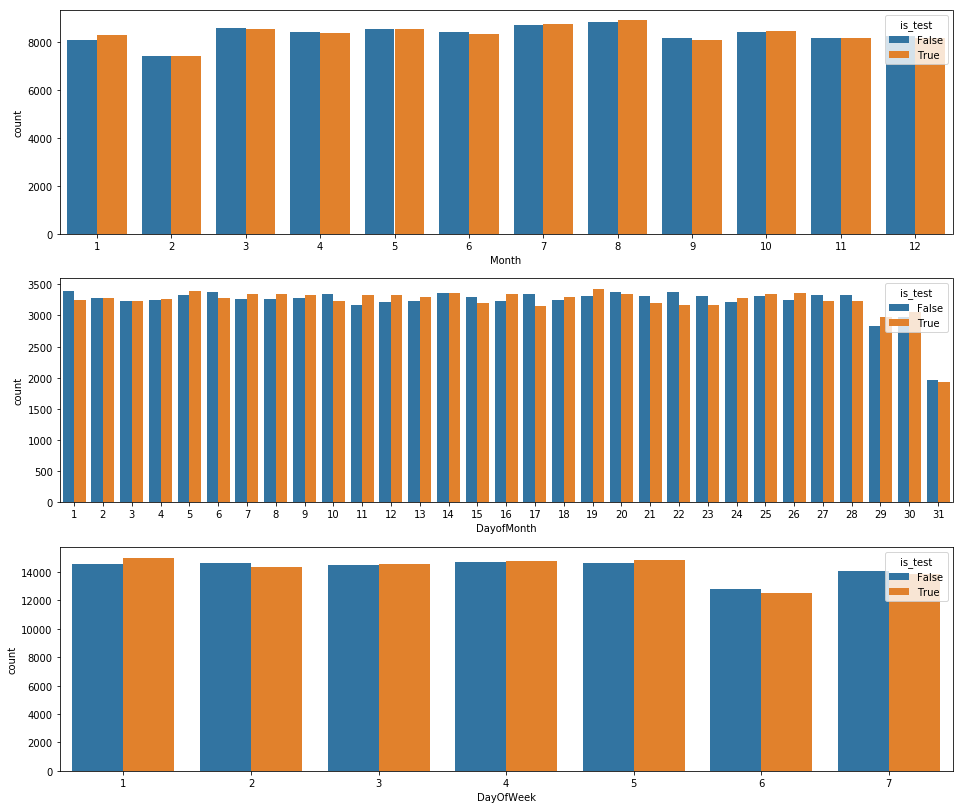

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

sns.countplot(df['Month'], hue=df['is_test'], ax=axes[0]);
sns.countplot(df['DayofMonth'], hue=df['is_test'], ax=axes[1]);
sns.countplot(df['DayOfWeek'], hue=df['is_test'], ax=axes[2]);

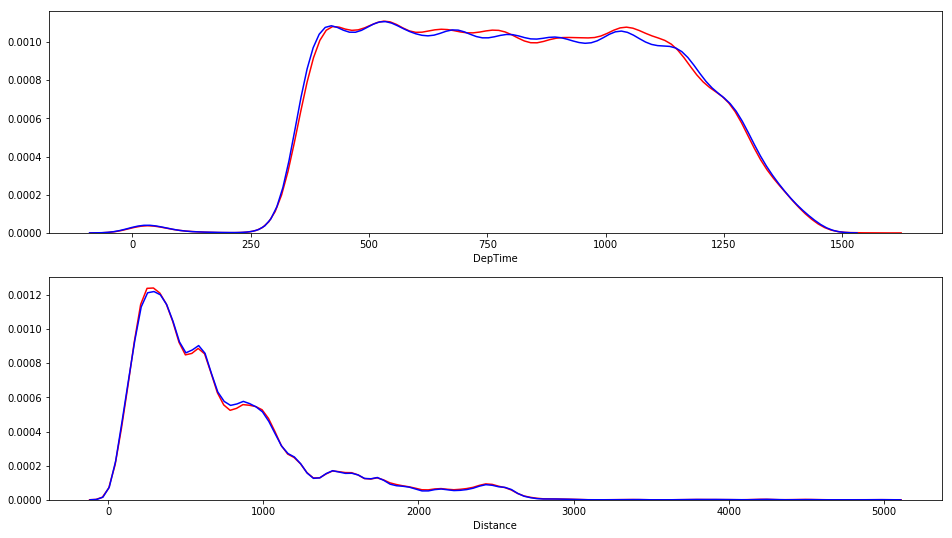

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(16, 9))

sns.distplot(df.loc[df['is_test']==False, 'DepTime'], ax=axes[0], color='red', hist=False);
sns.distplot(df.loc[df['is_test']==True, 'DepTime'], ax=axes[0], color='blue', hist=False);

sns.distplot(df.loc[df['is_test']==False, 'Distance'], ax=axes[1], color='red', hist=False);
sns.distplot(df.loc[df['is_test']==True, 'Distance'], ax=axes[1], color='blue', hist=False);

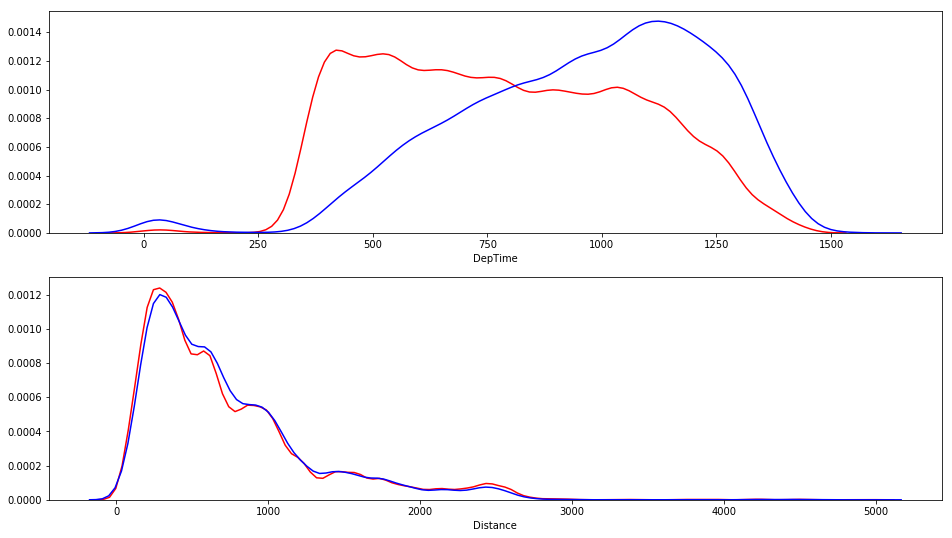

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(16, 9))

sns.distplot(df.loc[df['target']==False, 'DepTime'], ax=axes[0], color='red', hist=False);
sns.distplot(df.loc[df['target']==True, 'DepTime'], ax=axes[0], color='blue', hist=False);

sns.distplot(df.loc[df['target']==False, 'Distance'], ax=axes[1], color='red', hist=False);
sns.distplot(df.loc[df['target']==True, 'Distance'], ax=axes[1], color='blue', hist=False);

In [ ]:
[0, 500, 1300, 3000, 10000]

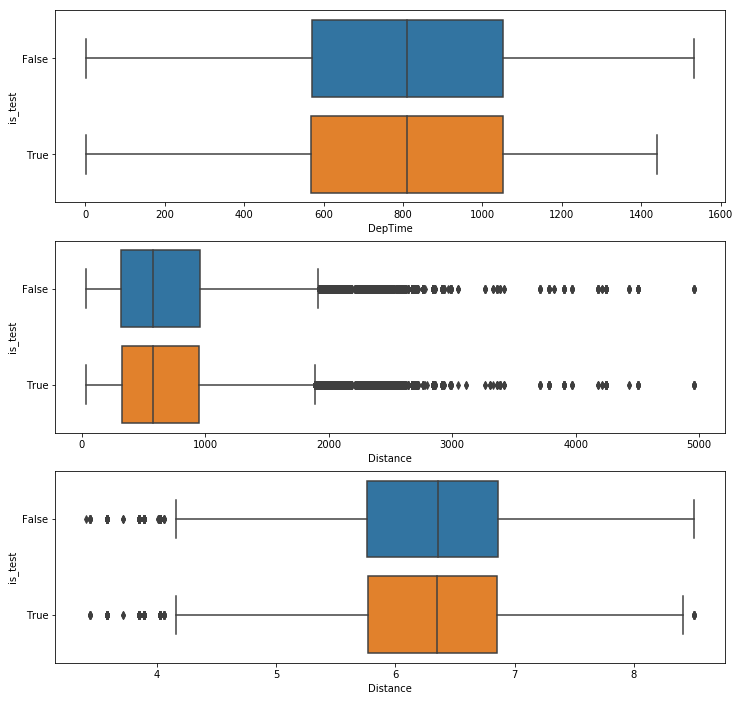

In [40]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

sns.boxplot(df['DepTime'], df['is_test'], ax=axes[0], orient='hor');
sns.boxplot(df['Distance'], df['is_test'], ax=axes[1], orient='hor');
sns.boxplot(df['Distance'].apply(np.log), df['is_test'], ax=axes[2], orient='hor');

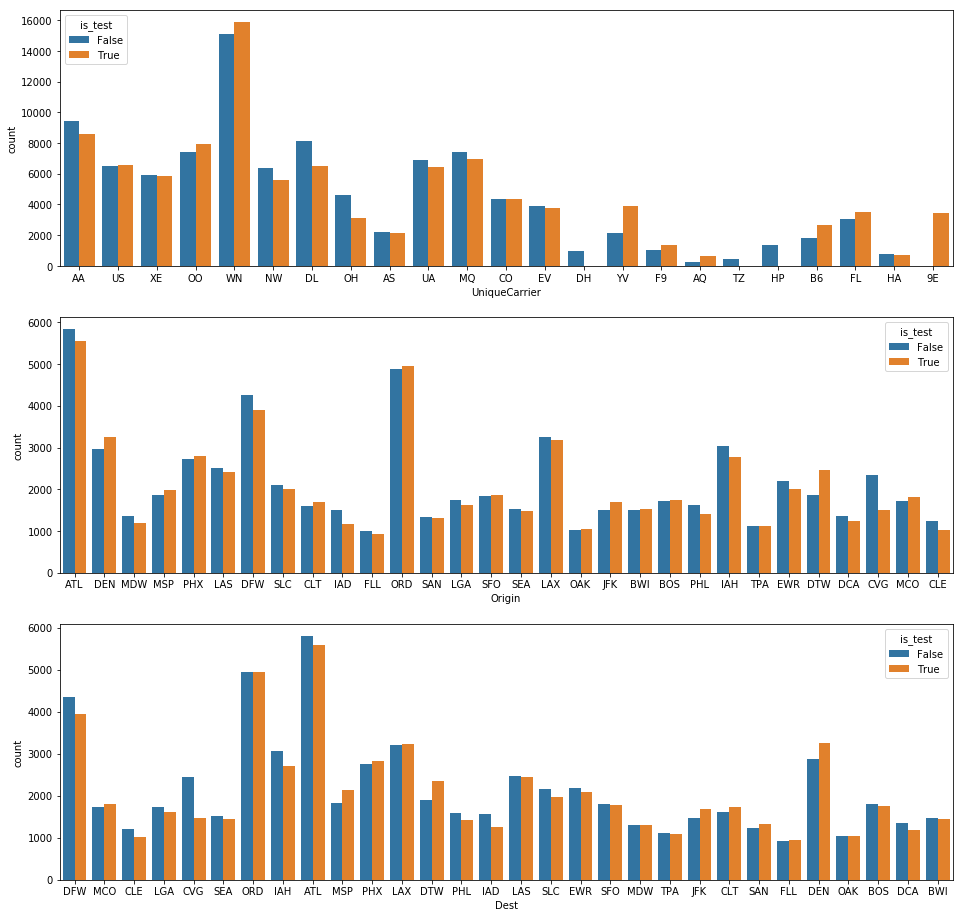

In [53]:
fig, axes = plt.subplots(3, 1, figsize=(16, 16))

sns.countplot(df['UniqueCarrier'], hue=df['is_test'], ax=axes[0]);

n_dep = 30
for i, col in enumerate(['Origin', 'Dest']):
    or_df = df.loc[df[col].isin(df[col].value_counts()[:n_dep].index.tolist())]
    sns.countplot(col, hue='is_test', data=or_df, ax=axes[i + 1]);

#### Analyze target

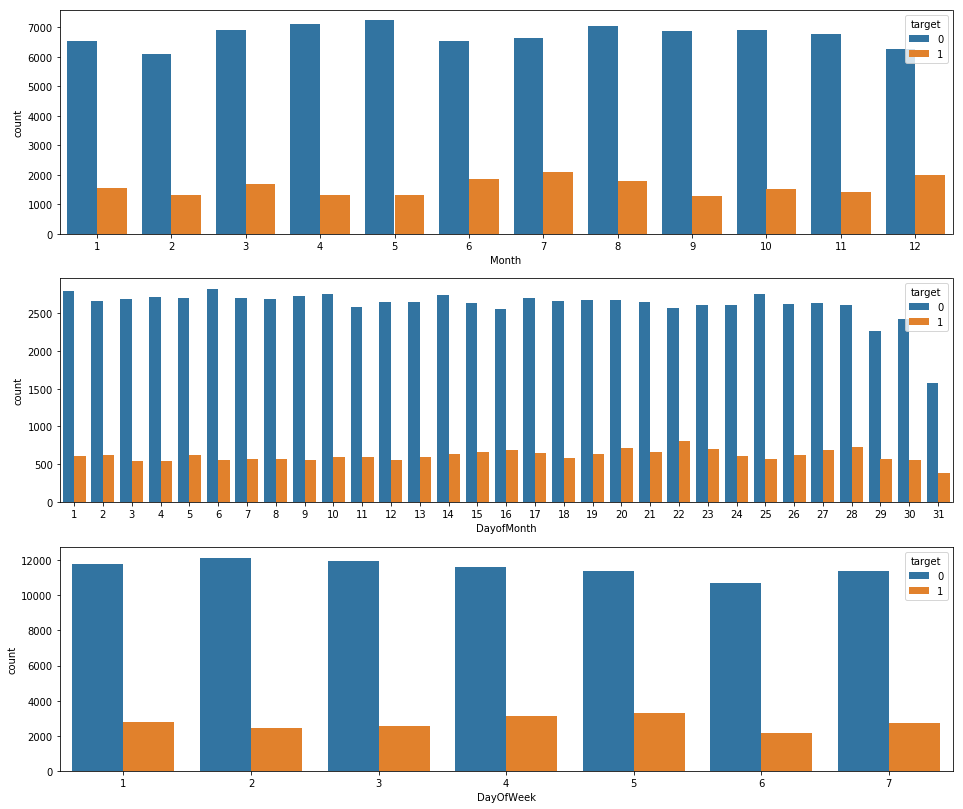

In [42]:
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

sns.countplot(train_df['Month'], hue=train_df['target'], ax=axes[0]);
sns.countplot(train_df['DayofMonth'], hue=train_df['target'], ax=axes[1]);
sns.countplot(train_df['DayOfWeek'], hue=train_df['target'], ax=axes[2]);

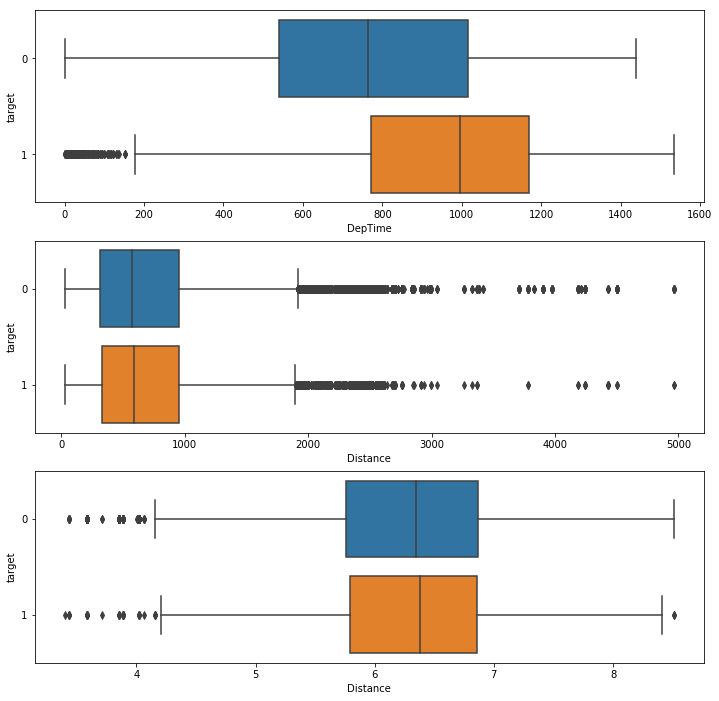

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

sns.boxplot(train_df['DepTime'], train_df['target'], ax=axes[0], orient='hor');
sns.boxplot(train_df['Distance'], train_df['target'], ax=axes[1], orient='hor');
sns.boxplot(train_df['Distance'].apply(np.log), train_df['target'], ax=axes[2], orient='hor');

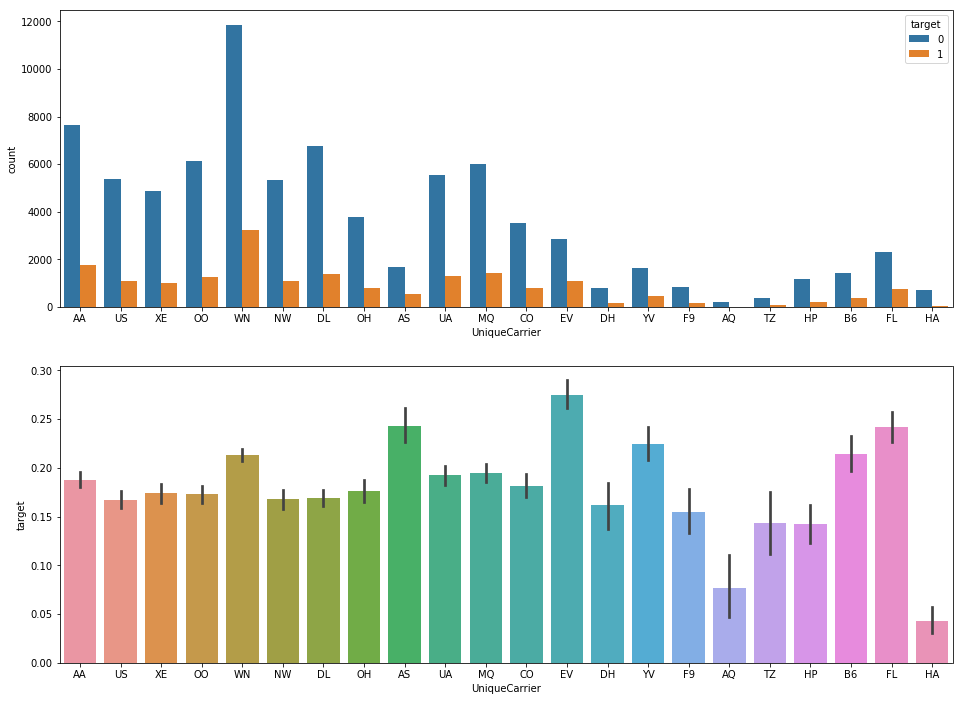

In [41]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

sns.countplot(train_df['UniqueCarrier'], hue=train_df['target'], ax=axes[0]);
sns.barplot(train_df['UniqueCarrier'], train_df['target'], ax=axes[1]);

In [15]:
df['UniqueCarrier'].value_counts().index

Index(['WN', 'AA', 'OO', 'DL', 'MQ', 'UA', 'US', 'NW', 'XE', 'CO', 'EV', 'OH',
       'FL', 'YV', 'B6', 'AS', '9E', 'F9', 'HA', 'HP', 'DH', 'AQ', 'TZ'],
      dtype='object')

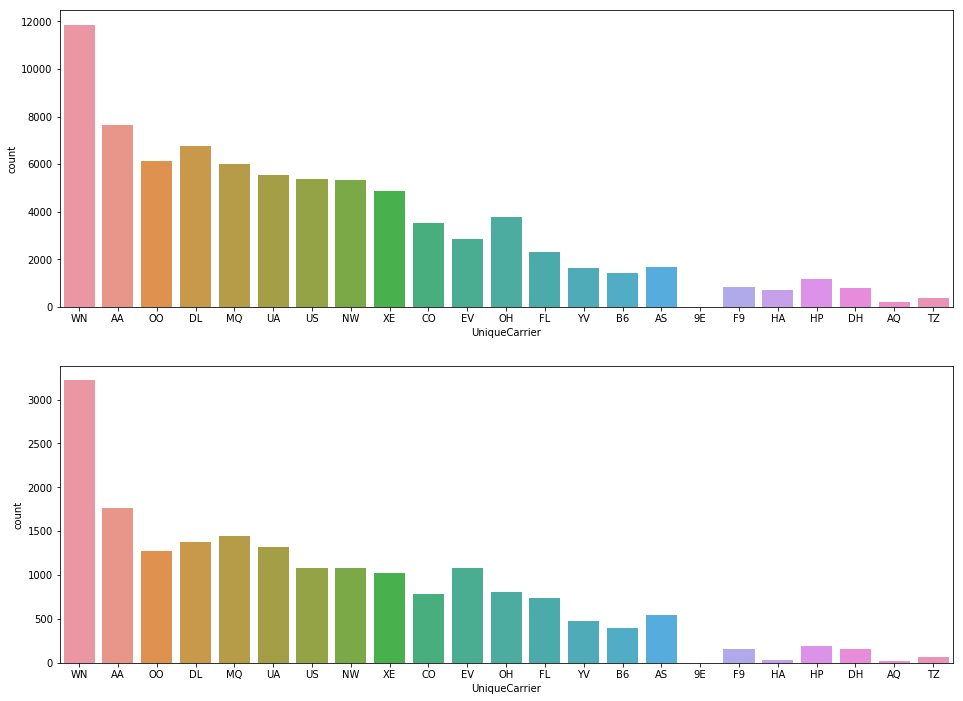

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

order = df['UniqueCarrier'].value_counts().index
sns.countplot(train_df.loc[train_df['target']==0, 'UniqueCarrier'], ax=axes[0], order=order);
sns.countplot(train_df.loc[train_df['target']==1, 'UniqueCarrier'], ax=axes[1], order=order);

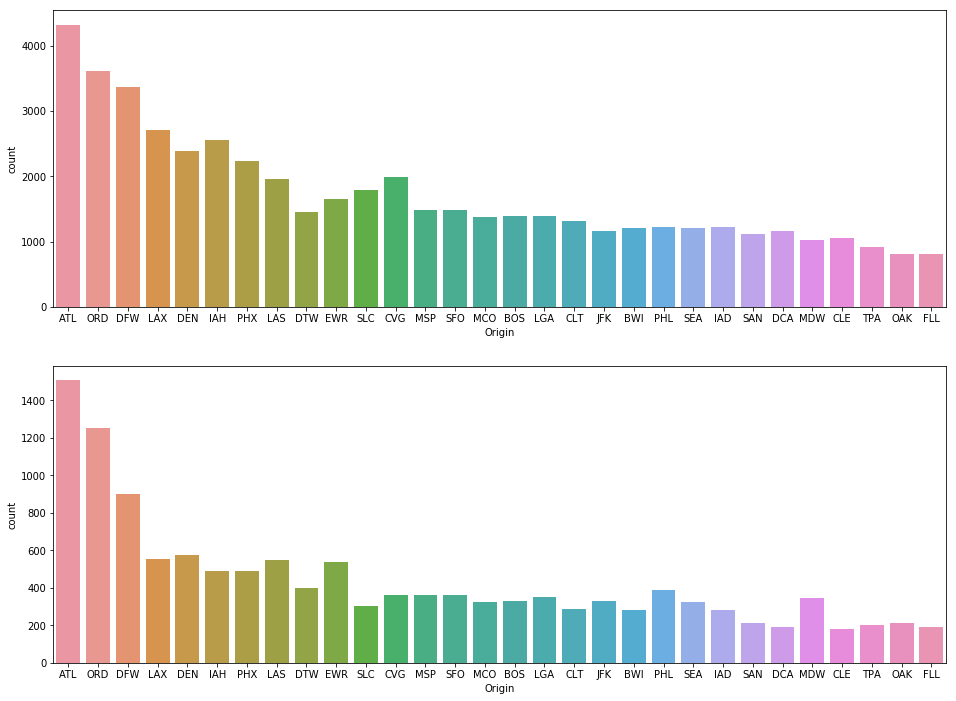

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

order = df['Origin'].value_counts().index[:30]
sns.countplot(train_df.loc[train_df['target']==0, 'Origin'], ax=axes[0], order=order);
sns.countplot(train_df.loc[train_df['target']==1, 'Origin'], ax=axes[1], order=order);

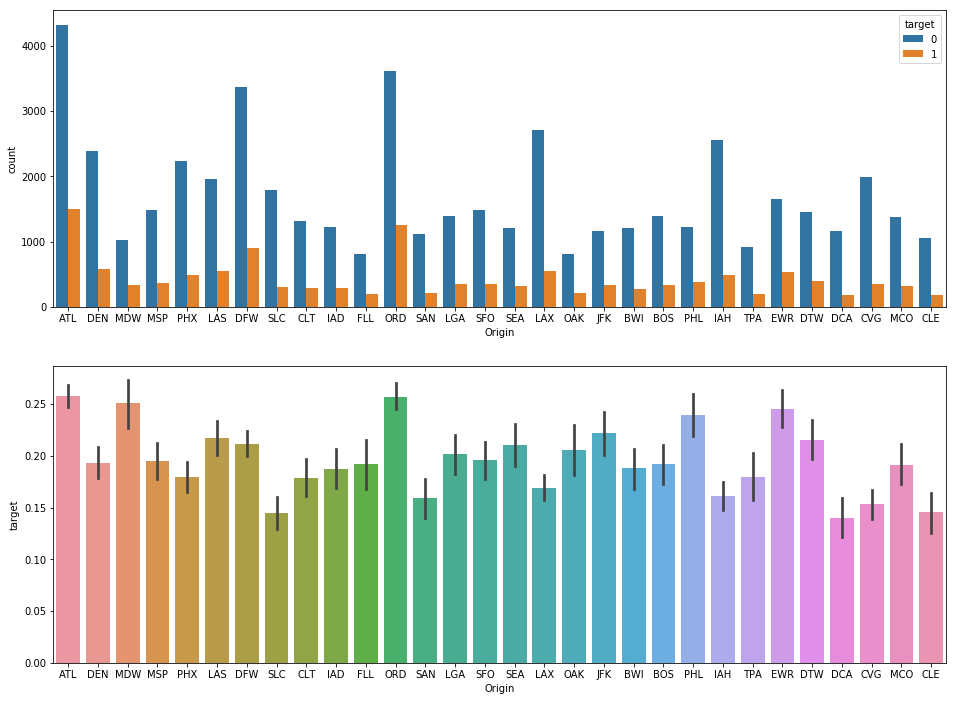

In [56]:
n_dep = 30
col = 'Origin'

fig, axes = plt.subplots(2, 1, figsize=(16, 12))

or_df = train_df.loc[train_df[col].isin(train_df[col].value_counts()[:n_dep].index.tolist())]

sns.countplot(col, hue='target', data=or_df, ax=axes[0]);
sns.barplot(col, 'target', data=or_df, ax=axes[1]);

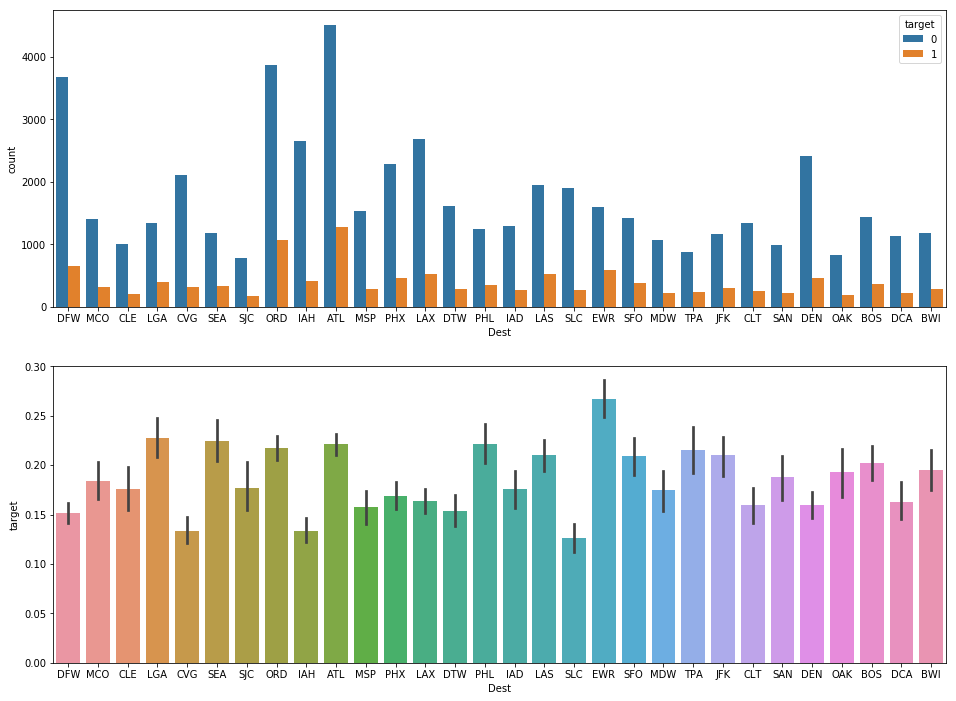

In [57]:
n_dep = 30
col = 'Dest'

fig, axes = plt.subplots(2, 1, figsize=(16, 12))

or_df = train_df.loc[train_df[col].isin(train_df[col].value_counts()[:n_dep].index.tolist())]

sns.countplot(col, hue='target', data=or_df, ax=axes[0]);
sns.barplot(col, 'target', data=or_df, ax=axes[1]);

In [5]:
train_df['Month'].value_counts()

8     8830
7     8706
3     8595
5     8543
6     8414
4     8408
10    8405
12    8265
11    8178
9     8163
1     8075
2     7418
Name: Month, dtype: int64

In [6]:
train_df['DayofMonth'].value_counts()

1     3399
20    3380
6     3377
22    3374
14    3366
17    3347
10    3342
27    3330
5     3321
28    3321
25    3314
23    3314
21    3312
19    3305
15    3297
2     3285
9     3283
7     3272
8     3258
4     3249
18    3246
26    3241
16    3240
13    3238
3     3228
12    3212
24    3210
11    3168
30    2976
29    2837
31    1958
Name: DayofMonth, dtype: int64

In [6]:
train_df['DayOfWeek'].value_counts()

c-4    14736
c-5    14657
c-2    14604
c-1    14569
c-3    14508
c-7    14097
c-6    12829
Name: DayOfWeek, dtype: int64

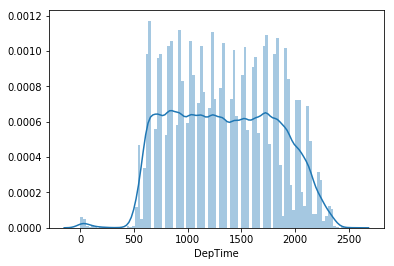

In [12]:
sns.distplot(train_df['DepTime'], bins=100);

In [15]:
train_df['UniqueCarrier'].value_counts()

WN    15082
AA     9418
DL     8128
MQ     7443
OO     7390
UA     6876
US     6482
NW     6403
XE     5901
OH     4594
CO     4334
EV     3930
FL     3039
AS     2222
YV     2128
B6     1838
HP     1378
F9     1006
DH      966
HA      762
TZ      446
AQ      234
Name: UniqueCarrier, dtype: int64

In [18]:
train_df['Origin'].value_counts()

ATL    5834
ORD    4870
DFW    4270
LAX    3259
IAH    3048
DEN    2973
PHX    2729
LAS    2513
CVG    2346
EWR    2196
SLC    2103
DTW    1863
MSP    1856
SFO    1839
LGA    1737
BOS    1731
MCO    1708
PHL    1617
CLT    1611
SEA    1526
IAD    1516
BWI    1497
JFK    1496
MDW    1366
DCA    1354
SAN    1338
CLE    1241
TPA    1122
OAK    1025
FLL     999
       ... 
EYW       9
STX       8
LWS       8
ISO       8
WRG       8
ACY       8
HKY       7
HVN       7
APF       7
BRW       7
TUP       6
BPT       6
DLG       5
ACK       5
ADQ       5
PSE       4
LWB       4
SCC       4
PIE       3
BLI       3
OAJ       2
RFD       2
AKN       2
TEX       2
VIS       1
WYS       1
ADK       1
GST       1
VCT       1
ILG       1
Name: Origin, Length: 289, dtype: int64

In [19]:
train_df['Dest'].value_counts()

ATL    5795
ORD    4933
DFW    4337
LAX    3205
IAH    3056
DEN    2866
PHX    2749
LAS    2475
CVG    2434
EWR    2190
SLC    2170
DTW    1898
MSP    1822
SFO    1808
BOS    1803
LGA    1741
MCO    1728
CLT    1604
PHL    1600
IAD    1577
SEA    1520
JFK    1467
BWI    1461
DCA    1358
MDW    1295
SAN    1229
CLE    1218
TPA    1121
OAK    1030
SJC     960
       ... 
HVN      10
MQT      10
BPT       9
FLG       9
ISO       9
SPI       9
CDV       8
BET       8
SCC       8
VIS       7
ADQ       7
CDC       7
RFD       6
BGM       5
HKY       5
PSE       5
PIE       5
WYS       4
BRW       3
BLI       3
AKN       3
GST       2
ILG       2
DLG       2
SOP       2
VCT       1
TTN       1
TEX       1
ACK       1
LWB       1
Name: Dest, Length: 289, dtype: int64

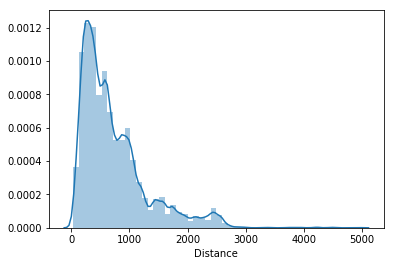

In [27]:
sns.distplot(train_df['Distance']);

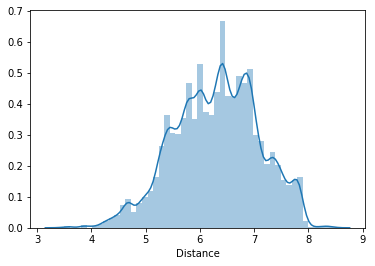

In [28]:
sns.distplot(train_df['Distance'].apply(np.log));

In [24]:
train_df['dep_delayed_15min'].value_counts()

N    80956
Y    19044
Name: dep_delayed_15min, dtype: int64

### Preproc

In [287]:
train_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_train.csv')
test_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_test.csv')

test_df.index = range(100000, 200000)

In [288]:
def upd_time(val):
    hour = val // 100
    minutes = val % 100
    if hour >= 24:
        hour = hour - 24
    return hour * 60 + minutes

def preproc(df, test=False):
    df['Month'] = df['Month'].apply(lambda x: int(x[2:]))
    df['DayofMonth'] = df['DayofMonth'].apply(lambda x: int(x[2:]))
    df['DayOfWeek'] = df['DayOfWeek'].apply(lambda x: int(x[2:]))
    
    df['DepTime'] = df['DepTime'].apply(upd_time)
    
    minutes_in_day = 24 * 60
    df['sin_time'] = np.sin(2 * np.pi * df['DepTime'] / minutes_in_day)
    df['cos_time'] = np.cos(2 * np.pi * df['DepTime'] / minutes_in_day)
    df['hour'] = df['DepTime'] // 60
    df['minutes'] = df['DepTime'] % 60
    
    df['Distance_orig'] = df['Distance'].values
    df['Distance'] = df['Distance'].apply(np.log)

    
    df.loc[~df['Origin'].isin(or_dest), 'Origin'] = 'other'
    df.loc[~df['Dest'].isin(or_dest), 'Dest'] = 'other'
    df.loc[~df['UniqueCarrier'].isin(unique_carrier), 'UniqueCarrier'] = 'other'
    
    if not test:
        le_carrier.fit(df['UniqueCarrier'])
        le_or_dest.fit(pd.concat([df['Origin'], df['Dest']]))
        del df['dep_delayed_15min']
    
    df['UniqueCarrier'] = le_carrier.transform(df['UniqueCarrier'])
    df['Origin'] = le_or_dest.transform(df['Origin'])
    df['Dest'] = le_or_dest.transform(df['Dest'])
    
    return df

In [289]:
le_carrier = LabelEncoder()
le_or_dest = LabelEncoder()
le_target = LabelEncoder()

In [290]:
unique_carrier = list(set(train_df['UniqueCarrier']) & set(test_df['UniqueCarrier']))
or_dest = list(set(train_df['Origin']) & set(test_df['Origin']) & set(train_df['Dest']) & set(test_df['Dest']))

# train_df.loc[~train_df['Origin'].isin(or_dest), 'Origin'] = 'other'
# train_df.loc[~train_df['Dest'].isin(or_dest), 'Dest'] = 'other'
# train_df.loc[~train_df['UniqueCarrier'].isin(unique_carrier), 'UniqueCarrier'] = 'other'

# test_df.loc[~test_df['Origin'].isin(or_dest), 'Origin'] = 'other'
# test_df.loc[~test_df['Dest'].isin(or_dest), 'Dest'] = 'other'
# test_df.loc[~test_df['UniqueCarrier'].isin(unique_carrier), 'UniqueCarrier'] = 'other'

In [291]:
for df in [train_df, test_df]:
    for col in ['Origin', 'Dest']:
        df[col+'CITY'] = df[col].map(air_city)
        df[col+'STATE'] = df[col].map(air_state)
        df[col+'COUNTRY'] = df[col].map(air_country)

        df[col+'LATITUDE'] = df[col].map(air_lat)
        df[col+'LONGITUDE'] = df[col].map(air_long)

        df[col+'x_coord'] = np.cos(df[col+'LATITUDE']) * np.cos(df[col+'LONGITUDE'])
        df[col+'y_coord'] = np.cos(df[col+'LATITUDE']) * np.sin(df[col+'LONGITUDE'])
        df[col+'z_coord'] = np.sin(df[col+'LATITUDE'])
        
    df['x_coord'] = df['Originx_coord'] - df['Destx_coord']
    df['y_coord'] = df['Originy_coord'] - df['Desty_coord']
    df['z_coord'] = df['Originz_coord'] - df['Destz_coord']
    df['LATITUDE'] = df['OriginLATITUDE'] - df['DestLATITUDE']
    df['LONGITUDE'] = df['OriginLONGITUDE'] - df['DestLONGITUDE']

In [292]:
train_df['dep_delayed_15min'] = le_target.fit_transform(train_df['dep_delayed_15min'])
# train_df['OrDe'] = train_df['Origin'] + train_df['Dest']
# test_df['OrDe'] = test_df['Origin'] + test_df['Dest']

categ_cols = ['UniqueCarrier', 'Origin', 'Dest', 
              'OriginCITY', 'OriginSTATE', 'OriginCOUNTRY', 
              'DestCITY', 'DestSTATE', 'DestCOUNTRY']
train_df_fe, test_df_fe = freq_encode(train_df, test_df, columns=categ_cols)

train_df_mekf, test_df_mekf = mean_encode(train_df, test_df, columns=categ_cols, target_col='dep_delayed_15min', 
                                                        reg_method='k_fold', alpha=5, folds=5)

train_df_meem, test_df_meem = mean_encode(train_df, test_df, columns=categ_cols, target_col='dep_delayed_15min', 
                                                        reg_method='expanding_mean', alpha=5)

In [293]:
y = train_df['dep_delayed_15min']
X = preproc(train_df)
X_test = preproc(test_df, test=True)

X.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,OriginCITY,OriginSTATE,...,x_coord,y_coord,z_coord,LATITUDE,LONGITUDE,sin_time,cos_time,hour,minutes,Distance_orig
0,8,21,7,1174,0,17,77,6.595781,Atlanta,GA,...,0.646148,0.265882,-0.202054,0.74449,12.61026,-0.917060,0.398749,19,34,732
1,4,20,3,948,15,209,166,6.726233,Pittsburgh,PA,...,0.808264,-0.579577,0.496120,12.06258,1.08316,-0.838671,-0.544639,15,48,834
2,9,2,5,862,17,220,58,6.030685,Raleigh,NC,...,1.070441,-0.201557,-0.428957,-5.53325,3.06193,-0.580703,-0.814116,14,22,416
3,11,25,6,615,13,76,170,6.770789,Denver,CO,...,-0.075340,-1.265410,1.297894,4.81599,-14.69033,0.442289,-0.896873,10,15,872
4,10,7,6,1108,16,168,194,6.047372,Chicago,IL,...,-0.640000,-1.015991,-0.365084,0.48346,8.14175,-0.992546,0.121869,18,28,423


### Grid Search CV

In [105]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=38)

In [106]:
params = {
    'n_estimators': [50, 100, 250, 500],
    'max_depth': [3, 5, 7, 9, 11]
}

regr = xgb.XGBRegressor(random_state=42, n_jobs=-1, max_depth=7, n_estimators=250)

gscv = GridSearchCV(regr, params, cv=skf, scoring='roc_auc')

gscv.fit(X, y)

gscv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=250, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [107]:
gscv.best_score_

0.7551942290037679

### CV

In [164]:
# del X['UniqueCarrier'], X['Origin'], X['Dest'], X['OrDe']

In [230]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=38)

In [183]:
cols_to_use = ['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'DepTime']

X_train = pd.concat([X[cols_to_use], train_df_fe], axis=1)

regr = xgb.XGBRegressor(random_state=42, n_jobs=-1, max_depth=9, n_estimators=250)
cv_score = cross_val_score(regr, X_train, y, cv=skf, scoring='roc_auc')
print(f'{cv_score.mean():.5f}+-{cv_score.std():.5f}')

0.74956+-0.00107


In [302]:
cols_to_use = ['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'DepTime']
cols_fe = ['freq_UniqueCarrier', 'freq_Origin', 'freq_Dest', 
           'freq_OriginSTATE', 'freq_DestSTATE']

X_train = pd.concat([X[cols_to_use], train_df_fe[cols_fe]], axis=1)

regr = xgb.XGBRegressor(random_state=42, n_jobs=-1, max_depth=9, n_estimators=250)
cv_score = cross_val_score(regr, X_train, y, cv=skf, scoring='roc_auc')
print(f'{cv_score.mean():.5f}+-{cv_score.std():.5f}')

0.75063+-0.00422


In [305]:
cols_to_use = ['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'DepTime', 
               'OriginLATITUDE', 'OriginLONGITUDE', 'DestLATITUDE', 'DestLONGITUDE']
cols_fe = ['freq_UniqueCarrier', 'freq_Origin', 'freq_Dest']

X_train = pd.concat([X[cols_to_use], train_df_fe[cols_fe]], axis=1)

regr = xgb.XGBRegressor(random_state=42, n_jobs=-1, max_depth=9, n_estimators=250)
cv_score = cross_val_score(regr, X_train, y, cv=skf, scoring='roc_auc')
print(f'{cv_score.mean():.5f}+-{cv_score.std():.5f}')

0.75569+-0.00347


In [311]:
cols_to_use = ['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'DepTime',
               'OriginLATITUDE', 'OriginLONGITUDE', 'DestLATITUDE', 'DestLONGITUDE']
cols_fe = ['freq_UniqueCarrier', 'freq_Origin', 'freq_Dest', 
           'freq_OriginSTATE', 'freq_DestSTATE']

X_train = pd.concat([X[cols_to_use], train_df_fe[cols_fe]], axis=1)

regr = xgb.XGBRegressor(random_state=42, n_jobs=-1, max_depth=9, n_estimators=250)
cv_score = cross_val_score(regr, X_train, y, cv=skf, scoring='roc_auc')
print(f'{cv_score.mean():.5f}+-{cv_score.std():.5f}')

0.75350+-0.00155


# Train

In [312]:
cols_to_use = ['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'DepTime',
               'OriginLATITUDE', 'OriginLONGITUDE', 'DestLATITUDE', 'DestLONGITUDE']
cols_fe = ['freq_UniqueCarrier', 'freq_Origin', 'freq_Dest', 
           'freq_OriginSTATE', 'freq_DestSTATE']

X_train = pd.concat([X[cols_to_use], train_df_fe[cols_fe]], axis=1)

X_test_ = pd.concat([X_test[cols_to_use], test_df_fe[cols_fe]], axis=1)

In [313]:
regr = xgb.XGBRegressor(random_state=42, n_jobs=-1, max_depth=9, n_estimators=250)
regr.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=250, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [314]:
ctb_test_pred = regr.predict(X_test_)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv(PATH_TO_DATA / 'sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred
    sample_sub.to_csv(PATH_TO_DATA / 'ctb_pred3.csv')